## Emotion Recognition - Data Preparation


### 1-Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2 # OpenCV for image treatment
import glob
import warnings
from keras.layers import Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
img_size = 48
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data augmentation for images in real-time while your model is still training 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
batch_size = 64
from sklearn.model_selection import train_test_split

### 2. Import & Explore Dataset

In [5]:
df = pd.read_csv("/home/khalil/Bureau/PI_Face_Recognition/archive (1)/fer2013.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
df.head(3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [12]:
print('Number of rows :', df.shape[0] )
print ('Number of columns :', df.shape[1] )

Number of rows : 35887
Number of columns : 3


#### Function 1 : Transform Emotion Column - Map Numerical Value to Actual Emotions

In [14]:
# 7 Categories
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

def emotions_mapping(row):
    val = row["emotion"]
    if val == 0:
        return "Angry"
    elif val == 1:
        return "Disgust"
    elif val == 2:
        return "Fear"
    elif val == 3:
        return "Happy"
    elif val == 4:
        return "Sad"
    elif val == 5:
        return "Surprise"
    else:
        return "Neutral"

df["actual_emotion"] = df.apply(emotions_mapping, axis=1)

In [16]:
df.head(3)

,emotion,pixels,Usage,actual_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear


#### Ploting Data 

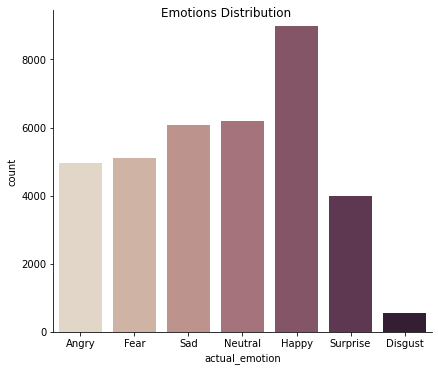

In [17]:
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.25", data=df, height=5, aspect=1.2)
ax.fig.suptitle("Emotions Distribution")
ax

#### Observation
##### The dataset is incredibly imbalanced.

In [48]:
df.actual_emotion.value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: actual_emotion, dtype: int64

#### Function 2: Reshape Pixels into Numpy Array with a shape of (48,48)

In [25]:
def transform_pixels(row):
    
    val = list(row["pixels"].split(' '))
    val = np.asarray(val, dtype=np.uint8)
    val = val.reshape((img_size, img_size))
    return val

df["numpy_pixels"] = df.apply(transform_pixels, axis=1)

In [26]:
df.head(3)

,emotion,pixels,Usage,actual_emotion,numpy_pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."


In [27]:
df['numpy_pixels'][0]

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

In [29]:
picture_list = df.groupby(["actual_emotion"]).head(5)
picture_list_0 = picture_list[picture_list.emotion == 0]
picture_list_1 = picture_list[picture_list.emotion == 1]
picture_list_2 = picture_list[picture_list.emotion == 2]
picture_list_3 = picture_list[picture_list.emotion == 3]
picture_list_4 = picture_list[picture_list.emotion == 4]
picture_list_5 = picture_list[picture_list.emotion == 5]
picture_list_6 = picture_list[picture_list.emotion == 6]

In [30]:
p_list = [picture_list_0, picture_list_1, picture_list_2, picture_list_3, picture_list_4, picture_list_5,picture_list_6]

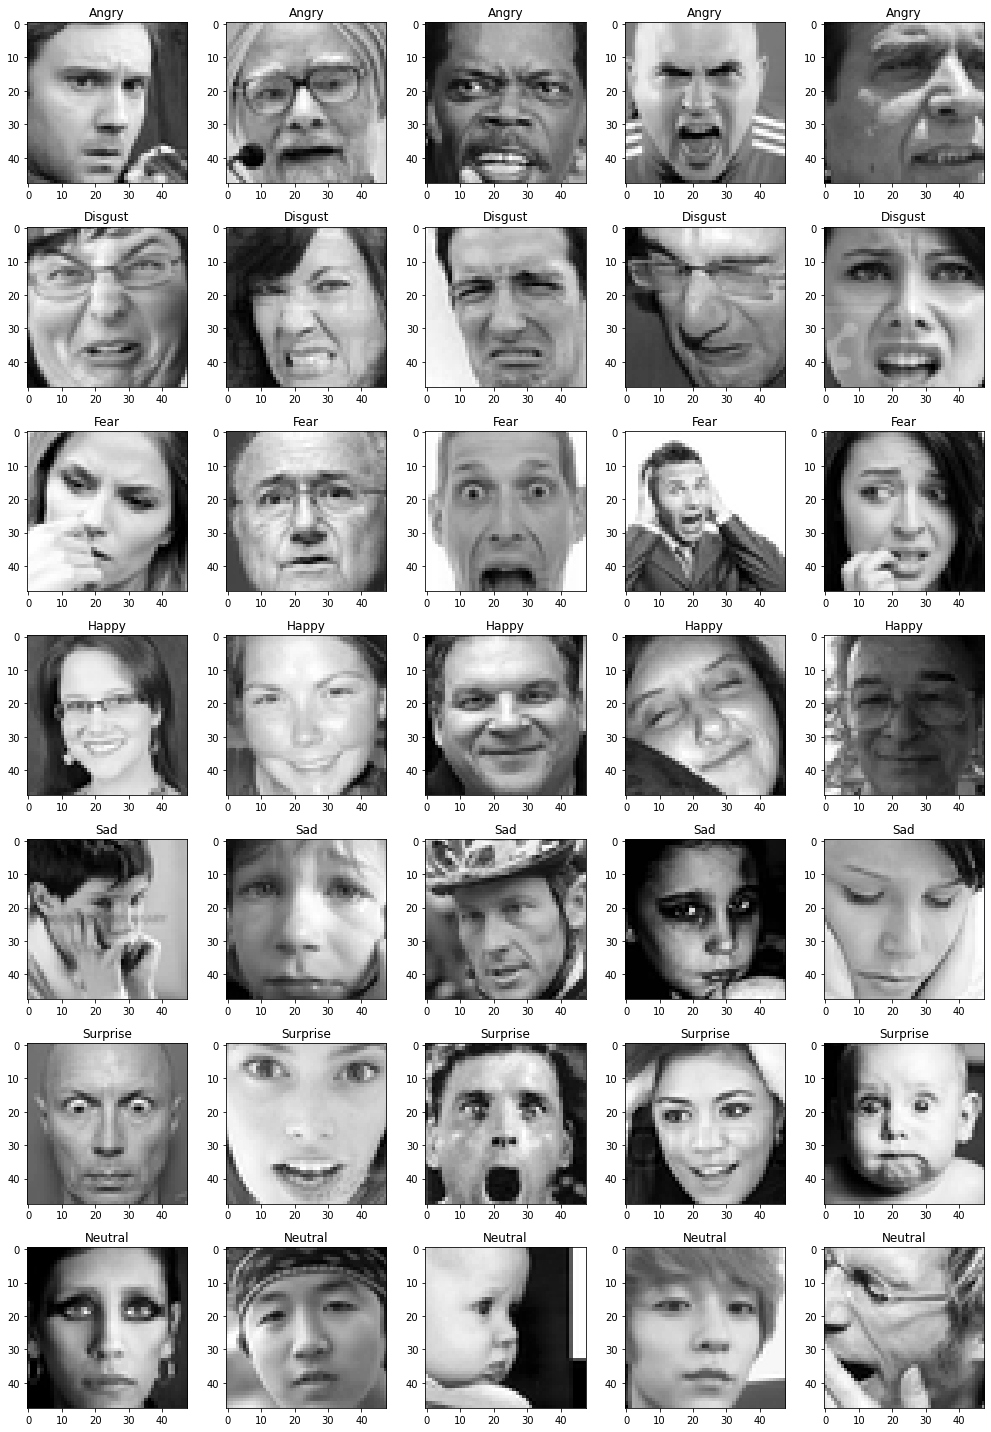

In [47]:
# Plot Images
from PIL import Image

plt.figure(0, figsize=(14, 20))
ctr = 0

for tl in p_list:
    for i, row in tl.iterrows():
        ctr += 1
        plt.subplot(7, 5, ctr, title=row["actual_emotion"])
        val = row["numpy_pixels"]
        img = Image.fromarray(val)
        plt.imshow(img, cmap='gist_gray')

plt.tight_layout()
plt.show()

#### Split Data into Train & Test

In [49]:
train = df[df.Usage == "Training"]

In [50]:
test  = df[df.Usage != "Training"]

In [51]:
train.shape

(28709, 5)

In [52]:
test.shape

(7178, 5)

#### Creating a list of array for faces

In [53]:
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)


In [56]:
faces.shape

(35887, 48, 48, 1)

#### Creating a list of array for emotions 

In [57]:
emotions = pd.get_dummies(df['emotion']).to_numpy()

In [61]:
emotions.shape

(35887, 7)

### 3. Generate Training & Validation Batches

In [64]:
# using ImageDataGenerator to normalize data and for data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Spliting Data
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

train_gen = train_datagen.flow(xtrain, ytrain, batch_size)
validation_gen = validation_datagen.flow(xtest, ytest, batch_size)